In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys

In [3]:
from matplotlib import pyplot as plt
from enum import Enum
import math
from IPython import display
%matplotlib inline

class ColorMode(Enum):
    RGB  = 0
    BGR  = 1
    Gray = 2
    RAW  = 3

def show(images, size=(16, 10), color_modes=ColorMode.RGB, subplots=None, titles=None, no_axis=False):
    
    if not isinstance(images, list):
        images = [images]
        
    l = len(images)
    
    if not isinstance(color_modes, list):
        color_modes = [color_modes] * l
        
    if not isinstance(titles, list):
        titles = [titles] * l
    
    if subplots is None:
        subplots = {'rows': math.ceil(l / 2), 'cols': 2}    
    elif 'rows' in subplots and 'cols' not in subplots:
        subplots['cols'] = math.ceil(l / subplots['rows'])        
    else:
        subplots['rows'] = math.ceil(l / subplots['cols'])        

    if isinstance(size, list) or isinstance(size, tuple):
        plt.figure(figsize=(size[0], size[1]))    
    else:
        plt.figure(figsize=(size, size))
    
       
    # plot images:
    for i, image in enumerate(images):
        if len(images) > 1:
            plt.subplot(subplots['rows'], subplots['cols'], i + 1)
        
        title = titles[i]        
        if title is not None:
            plt.title(title)
            
        color_mode = color_modes[i]
        
        if color_mode == ColorMode.RAW:
            plt.imshow(image)            
        else:
            img = image.copy()
            if img.dtype != np.uint8:
                img = np.interp(img, (img.min(), img.max()), (0, 255)).astype(np.uint8)   
            if color_mode == ColorMode.Gray:                
                if img.ndim > 2:
                    img = cv2.cvtColor(img[..., :3], cv2.COLOR_BGR2GRAY) if img.shape[2] >= 3 else img[..., 0]
                plt.imshow(img, cmap=plt.cm.gray)
            elif color_mode == ColorMode.BGR:
                plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            else:
                plt.imshow(img)

        if no_axis:
            plt.axis('off')
            plt.axis('tight')  
            plt.axis('image')
        
    plt.show()

In [4]:
sys.path.append(r"d:\projects\datasetannotation")

In [5]:
from dataset_utils.dataset.dataset import Dataset
from dataset_utils.hhi_tools import *

In [6]:
import fsdet

In [7]:
from fsdet import model_zoo

In [8]:
from fsdet.model_zoo import get_config_file

In [9]:
from fsdet.config import get_cfg
from fsdet.engine import DefaultPredictor

In [10]:
import torch
device = torch.device('cuda')
cpu_device = torch.device('cpu')

# load model

In [11]:
tested_models = [
    "COCO-detection/faster_rcnn_R_101_FPN_ft_all_3shot_unfreeze.yaml",
    "COCO-detection/faster_rcnn_R_101_FPN_ft_all_3shot.yaml",
    "COCO-detection/faster_rcnn_R_101_FPN_ft_fc_all_3shot.yaml",
    "COCO-detection/faster_rcnn_R_101_FPN_base.yaml"
]

In [12]:
model_i = 3

model_name = tested_models[model_i]
print(f"Testing model `{model_name}`")

config_path = os.path.join("configs", str(Path(model_name)))
weight_path = os.path.join("models", os.path.splitext(Path(model_name))[0] + ".pth")
mkdir(weight_path)

Testing model `COCO-detection/faster_rcnn_R_101_FPN_base.yaml`


In [13]:
if not os.path.exists(weight_path):
    print("weights not found:")
    model = model_zoo.get(model_name, trained=True)
    torch.save({"model": model.state_dict()}, weight_path)
else:
    print(f"weights found at `{weight_path}`, loading")
    
    cfg_file = get_config_file(model_name)
    cfg = get_cfg()
    cfg.merge_from_file(cfg_file)
    cfg.MODEL.WEIGHTS = weight_path
    if not torch.cuda.is_available():
        cfg.MODEL.DEVICE = "cpu"
    
    from fsdet.modeling import build_model
    model = build_model(cfg)
    from detectron2.checkpoint import DetectionCheckpointer
    DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)

weights found at `models\COCO-detection\faster_rcnn_R_101_FPN_base.pth`, loading


In [14]:
cfg = get_cfg()
cfg.merge_from_file(config_path)
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
# cfg.freeze()

# Dataset

In [15]:
from detectron2.structures import BoxMode

In [16]:
from fsdet.data.builtin_meta import _get_coco_instances_meta, _get_builtin_metadata

In [17]:
def dataset_loader(dataset, thing_classes):
    data = []
    for idx, sample in enumerate(dataset):
        image_path = sample['path']   
        width, height = sample.get('img_size', cv2.imread(image_path).shape[:2][::-1])
        
        annotation = {
            "file_name": image_path,
            "image_id" :  idx, # image unique ID
            "height" : height, # height of image
            "width" : width, # width of image
            "annotations": [
                {
                    'category_id': thing_classes.index(l['class_name']),
                    'bbox': l['object'].astype(np.int32).tolist(),
                    'bbox_mode': BoxMode.XYXY_ABS 
                } for l in sample.get('labels', []) ]
        }        
        data.append(annotation)
    return data

In [18]:
dataset = Dataset(r"E:\Datasets\GEC_Small\metadata.json")
train_data, _, novel_classes = dataset.split_training_data("accepted part", 
                                                           val_fraction=0, 
                                                           xyxy=True, 
                                                           unnormalize=True, 
                                                           trim=True)

In [19]:
SUBSET_SIZE = 5

random_subset = np.arange(len(train_data))
np.random.shuffle(random_subset)
random_subset = random_subset[:SUBSET_SIZE]
train_subset = [train_data[i] for i in random_subset]

In [20]:
base_classes = _get_builtin_metadata('coco_fewshot')['base_classes']
novel_classes = list(novel_classes.keys())
thing_classes = base_classes + novel_classes

In [21]:
metadata = {
    "thing_classes": thing_classes,
    "base_classes":  base_classes,
    "novel_classes": novel_classes,
}

In [42]:
from fsdet.evaluation.evaluator import DatasetEvaluator
from training.common.utils import compute_confusion_matrix, confusion_matrix_csv
class LZDVDatasetEvaluator(DatasetEvaluator):
    def __init__(self, dataset_name): # initial needed variables
        self._dataset_name = dataset_name
        
        meta = MetadataCatalog.get(dataset_name)
        self.test_data = {d['image_id']:d['annotations'] for d in DatasetCatalog.get(dataset_name)}
        self.thing_classes = meta.thing_classes
        self.novel_classes = meta.novel_classes 
        self.base_classes = meta.base_classes 

    def reset(self): # reset predictions
        self._predictions = []

    def process(self, inputs, outputs): # prepare predictions for evaluation        
        
        for i, o in zip(inputs, outputs):
            prediction = {
                "image_id": i["image_id"],
                "annotations": self.test_data.get(i["image_id"], []),
                "predictions": o.get("instances")
            }
            self._predictions.append(prediction)

    def evaluate(self):    
        gt = []
        dt = []
        
        for sample in self._predictions:
            _gt = []
            for obj in sample['annotations']:
                box = np.array(obj['bbox'])
                lbl = obj['category_id']
                _gt.append(np.hstack([box, lbl]))               
            gt.append(_gt)
            
            if sample["predictions"] is None:
                dt.append([])
                continue
            p = sample["predictions"]
            _dt = []
            for box, score, label in zip(p.pred_boxes, p.scores, p.pred_classes):
                box = box.detach().cpu().numpy()
                score = score.detach().cpu().item()
                label = label.detach().cpu().item() - len(self.base_classes)
                _dt.append(np.hstack([box, score, label]))
            dt.append(_dt)
            
#         for d,g in zip(dt, gt):
#             print("Detections:\n", d)
#             print("Truth:\n", g)
                        
        categories = self.novel_classes
            
        mAPs = {}        
        for thresh in range(50, 100, 5):
            cm = compute_confusion_matrix(dt, gt, categories, 0, thresh / 100.0)
            m = confusion_matrix_csv(cm, categories, iou_threshold=thresh / 100.0)[1]
            mAPs[thresh] = 0 if np.isnan(m) else m      
             
        from collections import OrderedDict
        ret = OrderedDict()
        ret['bbox'] = {
            "AP": np.mean(list(mAPs.values())),
            "AP50": mAPs[50],
            "AP75": mAPs[75],
        }
        
        return ret

In [23]:
from detectron2.data import DatasetCatalog, MetadataCatalog
def register_dataset(name, thing_classes, metadata):
    # register dataset (step 1)
    DatasetCatalog.pop(name, None)
    DatasetCatalog.register(
        name, # name of dataset, this will be used in the config file
        lambda: dataset_loader( # this calls your dataset loader to get the data
            train_subset, thing_classes, # inputs to your dataset loader
        ),
    )

    # register meta information (step 2)
    MetadataCatalog.get(name).set(
        thing_classes=metadata["thing_classes"], # all classes
        base_classes=metadata["base_classes"],  # base classes
        novel_classes=metadata["novel_classes"], # novel classes
        subset=train_subset
    )
    MetadataCatalog.get(name).evaluator_type = "lzdv_dataset" # set evaluator

In [24]:
datasets = {
    'lzdv_all': metadata["thing_classes"],
    'lzdv_base': metadata["base_classes"],
    'lzdv_novel': metadata["novel_classes"],
}
for dataset_name, classes in datasets.items():
    register_dataset(dataset_name, classes, metadata)

In [25]:
# modify the CFG:
cfg.DATASETS.TRAIN = ('lzdv_all',)
cfg.DATASETS.TEST = ('lzdv_novel',)

# surgery (remove)

First remove the last layer from the weights file by running

```bash
python3 -m tools.ckpt_surgery \
        --src1 checkpoints/coco/faster_rcnn/faster_rcnn_R_101_FPN_base/model_final.pth \
        --method remove \
        --save-dir checkpoints/coco/faster_rcnn/faster_rcnn_R_101_FPN_all
```

In [26]:
from tools import ckpt_surgery

In [27]:
from dataset_utils.tools.tools_containers import dict_to_obj, obj_to_dict

In [28]:
args = {
    "src1": weight_path,
    "src2": "",
    "method": "remove",
    "save_dir": os.path.dirname(weight_path),
    "param-name": ["roi_heads.box_predictor.cls_score", "roi_heads.box_predictor.bbox_pred"],
    "coco": False,
    "lvis": False,
    "tar-name": os.path.splitext(os.path.basename(weight_path))[0]
}

args = dict_to_obj(args)

In [29]:
remove_save_path = ckpt_surgery.ckpt_surgery(args)

save changed ckpt to models\COCO-detection\faster_rcnn_R_101_FPN_base_remove.pth


# train novel

Next, fine-tune the predictor on the novel set by running

```bash
python3 -m tools.train_net --num-gpus 8 \
        --config-file configs/COCO-detection/faster_rcnn_R_101_FPN_ft_novel_1shot.yaml \
        --opts MODEL.WEIGHTS checkpoints/coco/faster_rcnn/faster_rcnn_R_101_FPN_all/model_reset_remove.pth
```

In [30]:
from tools import train_net
from fsdet.config import get_cfg, set_global_cfg
from fsdet.engine import DefaultTrainer, default_argument_parser, default_setup

In [43]:
port = 2 ** 15 + 2 ** 14
args = {
    "config-file": config_path,
    "resume": False,
    "eval-only": False,
    "eval-all": False,
    "eval-during-train": False,
    "eval-iter": -1,
    "start-iter": -1,
    "end-iter": -1,
    "num-gpus": 1,
    "num-machines": 1,
    "machine-rank": 0,
    "dist-url": f"tcp://127.0.0.1:{port}",
    "opts": ["MODEL.WEIGHTS", remove_save_path, 
             "MODEL.ROI_HEADS.NUM_CLASSES", len(thing_classes),
             "OUTPUT_DIR", os.path.splitext(weight_path)[0],
             "SOLVER.IMS_PER_BATCH", "2",
             "SOLVER.MAX_ITER", "100",
             "DATALOADER.NUM_WORKERS", "1"]
}
args = dict_to_obj(args)

In [44]:
new_cfg = cfg.clone()
new_cfg.merge_from_list(args.opts)

In [45]:
new_cfg.freeze();
set_global_cfg(new_cfg);
default_setup(new_cfg, args);

[06/08 20:50:59 detectron2]: Rank of current process: 0. World size: 1
[06/08 20:50:59 detectron2]: Command line arguments: <dataset_utils.tools.tools_containers.dict_to_obj.<locals>.AnonymousObject object at 0x0000027393735108>
[06/08 20:50:59 detectron2]: Contents of args.config_file=configs\COCO-detection\faster_rcnn_R_101_FPN_base.yaml:
_BASE_: "../Base-RCNN-FPN.yaml"
MODEL:
  WEIGHTS: "detectron2://ImageNetPretrained/MSRA/R-101.pkl"
  MASK_ON: False
  RESNETS:
    DEPTH: 101
  ROI_HEADS:
    NUM_CLASSES: 60
DATASETS:
  TRAIN: ('coco_trainval_base',)
  TEST: ('coco_test_base',)
SOLVER:
  IMS_PER_BATCH: 16
  STEPS: (85000, 100000)
  MAX_ITER: 110000
OUTPUT_DIR: "checkpoints/coco/faster_rcnn/faster_rcnn_R_101_FPN_base"

[06/08 20:50:59 detectron2]: Full config saved to D:\PROJECTS\LZDV\few-shot-object-detection-kovalenko\models\COCO-detection\faster_rcnn_R_101_FPN_base\config.yaml
[06/08 20:50:59 d2.utils.env]: Using a generated random seed 59377921


In [46]:
trainer = train_net.Trainer(new_cfg, custom_evaluator=LZDVDatasetEvaluator)
trainer.set_evaluator(LZDVDatasetEvaluator)
trainer.resume_or_load(resume=args.resume)
trainer.train()

[06/08 20:51:00 d2.data.build]: Removed 0 images with no usable annotations. 5 images left.
[06/08 20:51:00 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[06/08 20:51:00 d2.data.build]: Using training sampler TrainingSampler
[06/08 20:51:00 d2.data.common]: Serializing 5 elements to byte tensors and concatenating them all ...
[06/08 20:51:00 d2.data.common]: Serialized dataset takes 0.00 MiB
WARNING [06/08 20:51:00 d2.solver.build]: SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.
[06/08 20:51:00 fvcore.common.checkpoint]: [Checkpointer] Loading from models\COCO-detection\faster_rcnn_R_101_FPN_base_remove.pth ...
[06/08 20:51:00 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                

WARNING [06/08 20:51:00 fvcore.common.checkpoint]: Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
[06/08 20:51:00 d2.engine.train_loop]: Starting training from iteration 0
[06/08 20:51:09 d2.utils.events]:  eta: 0:00:27  iter: 19  total_loss: 0.6606  loss_cls: 0.5063  loss_box_reg: 0.1195  loss_rpn_cls: 0.01045  loss_rpn_loc: 0.00317  time: 0.4168  data_time: 0.0523  lr: 0.0038162  max_mem: 5230M
[06/08 20:51:17 d2.utils.events]:  eta: 0:00:20  iter: 39  total_loss: 0.2426  loss_cls: 0.1327  loss_box_reg: 0.1031  loss_rpn_cls: 0.0002512  loss_rpn_loc: 0.003877  time: 0.3953  data_time: 0.0011  lr: 0.0078122  max_mem: 5230M
[06/08 20:51:24 d2.utils.events]:  eta: 0:00:13  iter: 59  total_loss: 0.07366  loss_cls: 0.02163  loss_box_reg: 0.04441  loss_rpn_cls: 0.0002402  loss_rpn_loc: 0.002331  time: 0.3836  data_time: 0.0012  lr: 0.011808  max_mem: 5230M
[06/08 20:51:34 d2.

d:\projects\datasetannotation\training\common\utils.py:134: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = float(confusion_matrix[i, i] / total_predicted)


OrderedDict([('bbox', {'AP': 0.9, 'AP50': 1.0, 'AP75': 1.0})])

In [47]:
trained_novel_path = os.path.join(os.path.splitext(weight_path)[0], "model_final.pth")

# surgery (combine base + novel)

Finally, combine the base weights from the base model with the novel weights by running

```bash
python3 -m tools.ckpt_surgery \
        --src1 checkpoints/coco/faster_rcnn/faster_rcnn_R_101_FPN_base/model_final.pth \
        --src2 checkpoints/coco/faster_rcnn/faster_rcnn_R_101_FPN_ft_novel_1shot/model_final.pth \
        --method combine \
        --save-dir checkpoints/coco/faster_rcnn/faster_rcnn_R_101_FPN_all
        --coco
```

In [48]:
args = {
    "src1": weight_path,
    "src2": trained_novel_path,
    "method": "combine",
    "save_dir": os.path.dirname(weight_path),
    "param-name": ["roi_heads.box_predictor.cls_score", "roi_heads.box_predictor.bbox_pred"],
    "coco": False,
    "lvis": False,
    "tar-name": os.path.splitext(os.path.basename(weight_path))[0],
    "tar_size": 60,
}

args = dict_to_obj(args)

In [49]:
combined_save_path = ckpt_surgery.ckpt_surgery(args)

save changed ckpt to models\COCO-detection\faster_rcnn_R_101_FPN_base_combine.pth


# fine-tune

We will then fine-tune the last layer of the full model on a balanced dataset by running
```bash
python3 -m tools.train_net --num-gpus 8 \
        --config-file configs/PascalVOC-detection/split1/faster_rcnn_R_101_FPN_ft_all1_1shot.yaml \
        --opts MODEL.WEIGHTS $WEIGHTS_PATH
```
where `WEIGHTS_PATH` is the path to the weights obtained in the previous initialization step.

In [52]:
args = {
    "config-file": config_path,
    "resume": False,
    "eval-only": False,
    "eval-all": False,
    "eval-during-train": False,
    "eval-iter": -1,
    "start-iter": -1,
    "end-iter": -1,
    "num-gpus": 1,
    "num-machines": 1,
    "machine-rank": 0,
    "dist-url": f"tcp://127.0.0.1:{port}",
    "opts": ["MODEL.WEIGHTS", combined_save_path, 
             "OUTPUT_DIR", os.path.splitext(weight_path)[0],
             "MODEL.ROI_HEADS.NUM_CLASSES", len(thing_classes),
             "SOLVER.IMS_PER_BATCH", "2",
             "SOLVER.MAX_ITER", "100",
             "DATALOADER.NUM_WORKERS", "1"]
}
args = dict_to_obj(args)

In [53]:
combined_cfg = cfg.clone()
combined_cfg.defrost()

combined_cfg.merge_from_list(args.opts)

combined_cfg.freeze();
set_global_cfg(combined_cfg);
default_setup(combined_cfg, args);

[06/08 20:54:11 detectron2]: Rank of current process: 0. World size: 1
[06/08 20:54:11 detectron2]: Command line arguments: <dataset_utils.tools.tools_containers.dict_to_obj.<locals>.AnonymousObject object at 0x00000271EE196848>
[06/08 20:54:11 detectron2]: Contents of args.config_file=configs\COCO-detection\faster_rcnn_R_101_FPN_base.yaml:
_BASE_: "../Base-RCNN-FPN.yaml"
MODEL:
  WEIGHTS: "detectron2://ImageNetPretrained/MSRA/R-101.pkl"
  MASK_ON: False
  RESNETS:
    DEPTH: 101
  ROI_HEADS:
    NUM_CLASSES: 60
DATASETS:
  TRAIN: ('coco_trainval_base',)
  TEST: ('coco_test_base',)
SOLVER:
  IMS_PER_BATCH: 16
  STEPS: (85000, 100000)
  MAX_ITER: 110000
OUTPUT_DIR: "checkpoints/coco/faster_rcnn/faster_rcnn_R_101_FPN_base"

[06/08 20:54:11 detectron2]: Full config saved to D:\PROJECTS\LZDV\few-shot-object-detection-kovalenko\models\COCO-detection\faster_rcnn_R_101_FPN_base\config.yaml
[06/08 20:54:11 d2.utils.env]: Using a generated random seed 11470402


In [54]:
trainer = train_net.Trainer(combined_cfg, custom_evaluator=LZDVDatasetEvaluator)
trainer.set_evaluator(LZDVDatasetEvaluator)
trainer.resume_or_load(resume=args.resume)
trainer.train()

[06/08 20:54:14 d2.data.build]: Removed 0 images with no usable annotations. 5 images left.
[06/08 20:54:14 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[06/08 20:54:14 d2.data.build]: Using training sampler TrainingSampler
[06/08 20:54:14 d2.data.common]: Serializing 5 elements to byte tensors and concatenating them all ...
[06/08 20:54:14 d2.data.common]: Serialized dataset takes 0.00 MiB
WARNING [06/08 20:54:14 d2.solver.build]: SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.
[06/08 20:54:14 fvcore.common.checkpoint]: [Checkpointer] Loading from models\COCO-detection\faster_rcnn_R_101_FPN_base_combine.pth ...
WARNING [06/08 20:54:14 d2.checkpoint.c2_model_loading]: Shape of roi_heads.box_predictor.bbox_pred.bias in checkpoint is torch.Size([240]), while shape of roi_heads.box_predictor.bbox_pred

WARNING [06/08 20:54:15 fvcore.common.checkpoint]: Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (240,) in the checkpoint but (244,) in the model! You might want to double check if this is expected.
WARNING [06/08 20:54:15 fvcore.common.checkpoint]: Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (240, 1024) in the checkpoint but (244, 1024) in the model! You might want to double check if this is expected.
WARNING [06/08 20:54:15 fvcore.common.checkpoint]: Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (61,) in the checkpoint but (62,) in the model! You might want to double check if this is expected.
WARNING [06/08 20:54:15 fvcore.common.checkpoint]: Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (61, 1024) in the checkpoint but (62, 1024) in the model! 

OrderedDict([('bbox', {'AP': 0.7857142857142858, 'AP50': 1.0, 'AP75': 1.0})])

In [55]:
final_save_path = os.path.join(os.path.splitext(weight_path)[0], "model_final.pth")

In [56]:
trainer.model

GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequential(
        (0): BottleneckBlock

# detect

In [57]:
model = trainer.model

In [58]:
model.eval();

In [59]:
import detectron2.data.transforms as T
transform_gen = T.ResizeShortestEdge(
            [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST],
            cfg.INPUT.MAX_SIZE_TEST,
        )

In [60]:
def default_predictor(model, original_image, transform, device=None):
    """
    Args:
        original_image (np.ndarray): an image of shape (H, W, C) (in BGR order).

    Returns:
        predictions (dict): the output of the model
    """
    # Apply pre-processing to image.
    height, width = original_image.shape[:2]
    image = transform.get_transform(original_image).apply_image(original_image)
    image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
    if device:
        image = image.to(device)

    inputs = {"image": image, "height": height, "width": width}
    predictions = model([inputs])[0]
    return predictions

In [61]:
test_dataset = Dataset(r"E:\Datasets\GEC_Datasets\GEC_Paper_Test\recordings\full_metadata.json")
# test_dataset = Dataset(r"E:\Datasets\COCO_2017\val2017.json")

In [72]:
idx = np.random.randint(len(test_dataset))
print(f"#{idx}")

#2995


In [73]:
image_data = test_dataset.get_item_data(idx, source=0)
image_path = test_dataset.get_image_path(image_data)
image = test_dataset.get_image(image_data)
image_format = image_data.get('image_format')

if 'rgb' in image_format.lower():
    image = image[...,::-1]    

In [74]:
predictions = default_predictor(model, image, transform_gen)

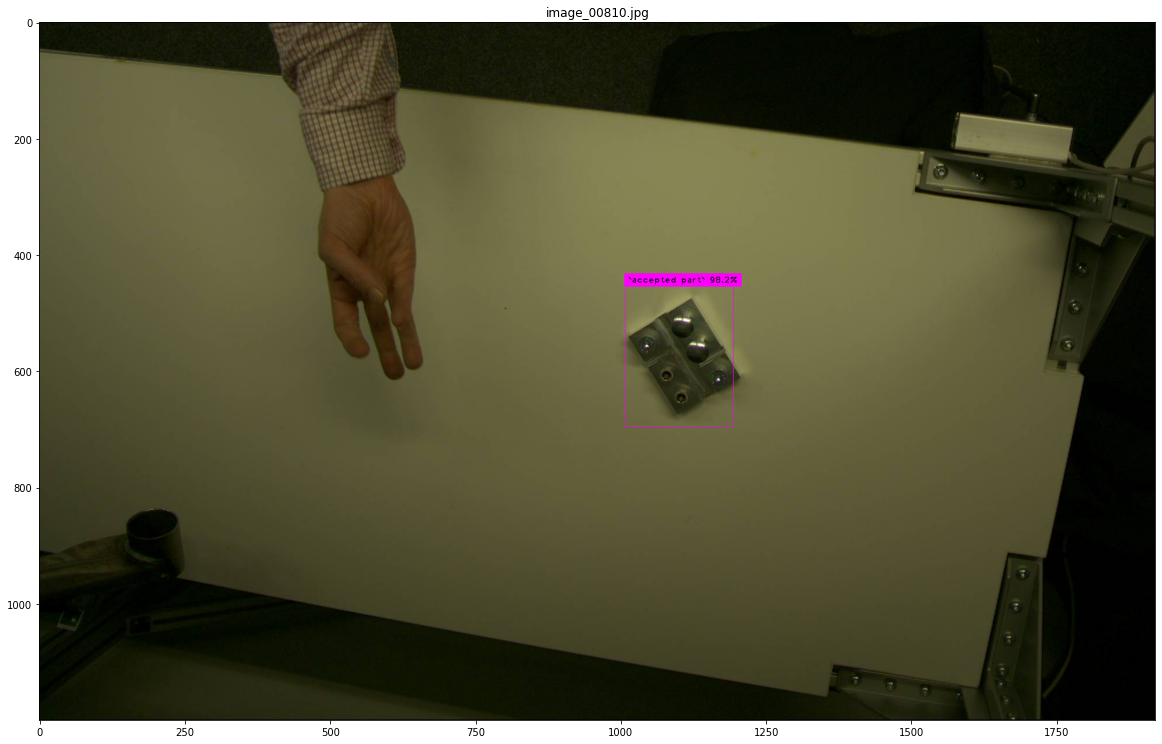

In [75]:
img = image.copy()
p = predictions["instances"]
for box, score, label in zip(p.pred_boxes, p.scores, p.pred_classes):    
    box = box.detach().cpu().numpy()
    x1,y1,x2,y2 = box.astype(np.int32)
    score = score.detach().cpu().item()
    label = label.detach().cpu().item()
    
    if score < 0.5: 
        continue
    
    cv2.rectangle(img, (x1, y1), (x2,y2), COLOR_MAGENTA, 1)
    class_name = thing_classes[label]
    draw_text(img, f"`{class_name}` {score*100:.1f}%", (x1, y1), valign=Valign.BOTTOM, font_size=1, 
              font_width=1, font_color=COLOR_BLACK, background_color=COLOR_MAGENTA)
    
show(img, color_modes=ColorMode.BGR, titles=os.path.basename(image_path), size=(20,20))